In [1]:
# Reproducibility
seed = 125

# Architecture
input_shape = (256, 256, 1)
kernel_shape = (3, 3)
pool_size = (2, 2)

# Training
fake_path = "./data/AI recognition dataset/fakeV2/fake-v2"
path_real = "./data/AI recognition dataset/real"
initial_learning_rate = 0.001
batch_size = 16
sample_frac = 1
epochs = 50
patience = 10
decay_after_n_epochs = 10
decay_rate = 0.5
verbose = 1
l2_regularization = 0.001
params = {
    "epochs": epochs,
    "batch_size": batch_size,
    "patience": patience,
    "seed": seed,
    "verbose": verbose,
    "sample_frac": sample_frac,
    "l2_regularization": l2_regularization
}

model_id = f"model_v{params['epochs']}_bs{params['batch_size']}_pat{params['patience']}_frac_{sample_frac}"
checkpoint_path = f"./checkpoints/{model_id}.keras"

In [2]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import layers, Model, mixed_precision
import keras.backend as K
import keras

import tensorflow as tf
from preprocessing.patch_generator import preprocess
from sklearn.model_selection import train_test_split
from typing import List, Tuple, Union
import matplotlib.pyplot as plt
import numpy as np
import json
import os

2025-05-04 15:32:12.897674: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-04 15:32:12.911140: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746383532.929156 2727435 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746383532.935552 2727435 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1746383532.948030 2727435 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [3]:
mixed_precision.set_global_policy('mixed_float16')

In [4]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"Available GPUs: {gpus}")

    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
else:
    print("No GPUs available.")

Available GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [5]:
print(tf.__version__)

2.19.0


I0000 00:00:1746383536.105229 2727435 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1767 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


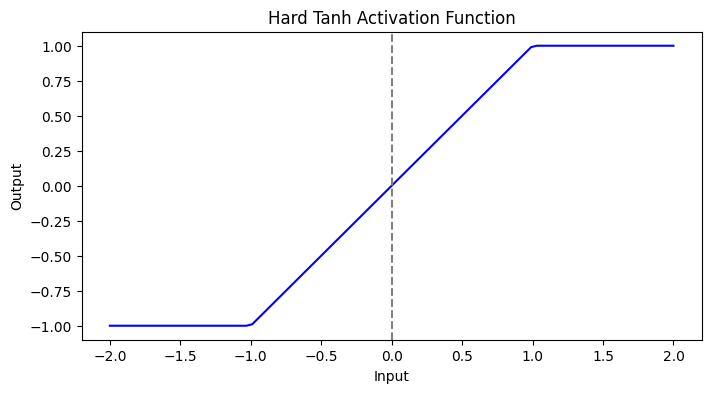

In [6]:
@tf.function
def hard_tanh(x) -> tf.Tensor:
    return tf.maximum(tf.minimum(x, 1), -1)

x_values = np.linspace(-2, 2, 100)
y_values = hard_tanh(tf.convert_to_tensor(x_values)).numpy()

plt.figure(figsize=(8, 4))
plt.plot(x_values, y_values, color="blue")
plt.title("Hard Tanh Activation Function")
plt.xlabel("Input")
plt.ylabel("Output")
plt.axvline(0, color="gray", linestyle="--")
plt.show()

In [7]:
def load_images(
    path: str,
    label: int,
    sample_frac: Union[int, float]) -> Tuple[List[str], List[int]]:
    imgs = [os.path.join(path, img) for img in os.listdir(path)]

    if isinstance(sample_frac, int) and sample_frac > 1:
        sample_count = min(sample_frac, len(imgs))
    else:
        sample_count = int(len(imgs) * sample_frac)

    sampled_imgs = imgs[:sample_count]
    labels = [label for _ in range(len(sampled_imgs))]
    return sampled_imgs, labels

ai_imgs, ai_label = load_images(fake_path, 1, sample_frac)
real_imgs, real_label = load_images(path_real, 0, sample_frac)

In [8]:
X = ai_imgs + real_imgs
y = ai_label + real_label

X_train, X_validate, y_train, y_validate = train_test_split(
    X, y, train_size=0.10, test_size=0.3, random_state=seed, stratify=y
)

def dict_map(X1, X2, y):
    return {"rich_texture": X1, "poor_texture": X2}, y

def set_shapes(frt, fpt, label=None):
    frt.set_shape(input_shape)
    fpt.set_shape(input_shape)
    if label is not None:
        label.set_shape([])
        return frt, fpt, label
    else:
        return frt, fpt

dataset = (
    tf.data.Dataset.from_tensor_slices((X_train, y_train))
    .shuffle(len(X_train), seed)
    .map(
        lambda filepath, label: tf.py_function(
            preprocess, [filepath, label], [tf.float64, tf.float64, tf.int32]
        )
    )
    .map(set_shapes)
    .map(dict_map)
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)

validation_set = (
    tf.data.Dataset.from_tensor_slices((X_validate, y_validate))
    .map(
        lambda filepath, label: tf.py_function(
            preprocess, [filepath, label], [tf.float64, tf.float64, tf.int32]
        )
    )
    .map(set_shapes)
    .map(dict_map)
    .batch(10)
    .prefetch(tf.data.AUTOTUNE)
)

In [9]:
from collections import Counter
Counter(y_validate)

Counter({1: 5357, 0: 1134})

In [10]:
REG_PARAMS = {"kernel_regularizer": keras.regularizers.l2(l2_regularization)}

class FeatureExtractionLayer(layers.Layer):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.conv = layers.Conv2D(filters=32, kernel_size=(3, 3), activation="relu", **REG_PARAMS)
        self.bn = layers.BatchNormalization()
        self.activation = layers.Lambda(hard_tanh)

    def call(self, input):
        x = self.conv(input)
        x = self.bn(x)
        x = self.activation(x)
        return x

input0 = layers.Input(shape=input_shape, name="rich_texture")
input1 = layers.Input(shape=input_shape, name="poor_texture")

l0 = FeatureExtractionLayer(name="feature_extraction_layer_rich_texture")(input0)
l1 = FeatureExtractionLayer(name="feature_extraction_layer_poor_texture")(input1)

contrast = layers.subtract((l0, l1))

x = layers.Conv2D(filters=32, kernel_size=kernel_shape, activation="relu", **REG_PARAMS)(contrast)
x = layers.BatchNormalization()(x)
for i in range(3):
    x = layers.Conv2D(filters=32, kernel_size=kernel_shape, activation="relu", **REG_PARAMS)(x)
    x = layers.BatchNormalization()(x)
x = layers.BatchNormalization()(x)

for i in range(4):
    x = layers.Conv2D(filters=32, kernel_size=kernel_shape, activation="relu", **REG_PARAMS)(x)
    x = layers.BatchNormalization()(x)
x = layers.AveragePooling2D(pool_size)(x)

for i in range(2):
    x = layers.Conv2D(filters=32, kernel_size=kernel_shape, activation="relu", **REG_PARAMS)(x)
    x = layers.BatchNormalization()(x)
x = layers.AveragePooling2D(pool_size)(x)

for i in range(2):
    x = layers.Conv2D(filters=32, kernel_size=kernel_shape, activation="relu", **REG_PARAMS)(x)
    x = layers.BatchNormalization()(x)
x = layers.GlobalAveragePooling2D()(x)

x = layers.Flatten()(x)
x = layers.Dense(1, activation="sigmoid", **REG_PARAMS)(x)

model = Model(
    inputs=(input0, input1), outputs=x, name="rt_pt_contrast"
)

steps_per_epoch  = int(len(X_train) / batch_size)
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=initial_learning_rate,
    decay_steps=steps_per_epoch * decay_after_n_epochs,
    decay_rate=decay_rate
)
optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)
model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=[keras.metrics.BinaryAccuracy(), keras.metrics.Recall(), keras.metrics.Precision()])
model.summary()

Model: "rt_pt_contrast"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ rich_texture        │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ poor_texture        │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cast (Cast)         │ (None, 256, 256,  │          0 │ rich_texture[0][… │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cast_1 (Cast)       │ (None, 256, 256,  │          0 │ poor_texture[0][… │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ feature_extraction… │ (None, 254, 254,  │        448 │ cast[0][0]        │
│ (FeatureExtraction… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ feature_extraction… │ (None, 254, 254,  │        448 │ cast_1[0][0]      │
│ (FeatureExtraction… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ subtract (Subtract) │ (None, 254, 254,  │          0 │ feature_extracti… │
│                     │ 32)               │            │ feature_extracti… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 252, 252,  │      9,248 │ subtract[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 252, 252,  │        128 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 250, 250,  │      9,248 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 250, 250,  │        128 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 248, 248,  │      9,248 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 248, 248,  │        128 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 246, 246,  │      9,248 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 246, 246,  │        128 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 246, 246,  │        128 │ batch_normalizat… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 244, 244,  │      9,248 │ batch_normalizat

 Total params: 113,569 (443.63 KB)

 Trainable params: 112,609 (439.88 KB)

 Non-trainable params: 960 (3.75 KB)

## Making data pipeline

In [11]:
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path, monitor="val_loss", save_best_only=True, verbose=verbose
)

early_stopping_callback = EarlyStopping(
    monitor="val_loss", patience=patience, verbose=verbose, restore_best_weights=True
)

## Training the model

In [12]:
history = model.fit(
    dataset,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    batch_size=batch_size,
    validation_data=validation_set,
    callbacks=[checkpoint_callback, early_stopping_callback],
)

Epoch 1/50


I0000 00:00:1746383550.133952 2727527 service.cc:152] XLA service 0x7fe5140e5860 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746383550.133998 2727527 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Laptop GPU, Compute Capability 8.6
2025-05-04 15:32:30.636917: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1746383553.915393 2727527 cuda_dnn.cc:529] Loaded cuDNN version 90900
2025-05-04 15:32:55.872850: E external/local_xla/xla/service/slow_operation_alarm.cc:73] Trying algorithm eng19{k2=4} for conv %cudnn-conv-bw-filter.16 = (f16[32,3,3,32]{3,2,1,0}, u8[0]{0}) custom-call(f16[16,254,254,32]{3,2,1,0} %bitcast.19710, f16[16,252,252,32]{3,2,1,0} %bitcast.19728), window={size=3x3}, dim_labels=b01f_o01i->b01f, custom_call_target="__cudnn$convBackwardFilter", metadata={op_type="Conv2DBackpropFi

 36/135 ━━━━━━━━━━━━━━━━━━━━ 4:33 3s/step - binary_accuracy: 0.6089 - loss: 1.0358 - precision: 0.8991 - recall: 0.5928

/home/llbs/www/cin/deep-learning/ai-generation-detection/.venv/lib/python3.12/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - binary_accuracy: 0.7104 - loss: 0.9565 - precision: 0.8996 - recall: 0.7303

2025-05-04 15:40:44.690620: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.



Epoch 1: val_loss improved from inf to 0.71972, saving model to ./checkpoints/model_v50_bs16_pat10_frac_1.keras
135/135 ━━━━━━━━━━━━━━━━━━━━ 1706s 12s/step - binary_accuracy: 0.7109 - loss: 0.9559 - precision: 0.8996 - recall: 0.7310 - val_binary_accuracy: 0.8452 - val_loss: 0.7197 - val_precision: 0.8422 - val_recall: 0.9996
Epoch 2/50
  1/135 ━━━━━━━━━━━━━━━━━━━━ 56:06 25s/step - binary_accuracy: 0.6667 - loss: 0.8082 - precision: 1.0000 - recall: 0.6667

/home/llbs/www/cin/deep-learning/ai-generation-detection/.venv/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_loss did not improve from 0.71972
135/135 ━━━━━━━━━━━━━━━━━━━━ 1152s 8s/step - binary_accuracy: 0.6667 - loss: 0.8082 - precision: 1.0000 - recall: 0.6667 - val_binary_accuracy: 0.8426 - val_loss: 0.7230 - val_precision: 0.8400 - val_recall: 0.9996
Epoch 3/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - binary_accuracy: 0.8862 - loss: 0.6727 - precision: 0.9121 - recall: 0.9532
Epoch 3: val_loss improved from 0.71972 to 0.71721, saving model to ./checkpoints/model_v50_bs16_pat10_frac_1.keras
135/135 ━━━━━━━━━━━━━━━━━━━━ 1509s 11s/step - binary_accuracy: 0.8862 - loss: 0.6725 - precision: 0.9121 - recall: 0.9533 - val_binary_accuracy: 0.8287 - val_loss: 0.7172 - val_precision: 0.9415 - val_recall: 0.8449
Epoch 4/50
  1/135 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - binary_accuracy: 1.0000 - loss: 0.4853 - precision: 1.0000 - recall: 1.0000
Epoch 4: val_loss did not improve from 0.71721
135/135 ━━━━━━━━━━━━━━━━━━━━ 1129s 8s/step - binary_accuracy: 1.0000 - loss: 0.4853 - precision: 1

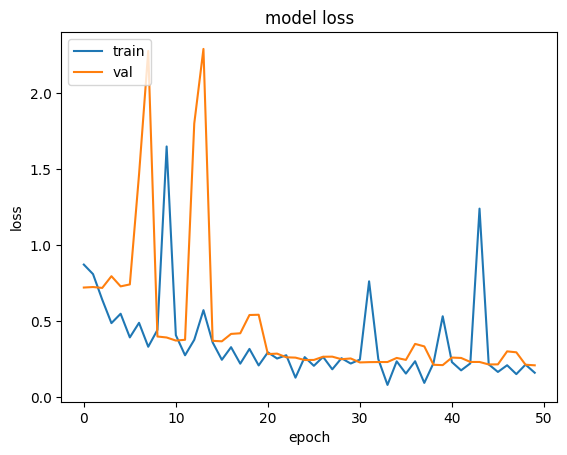

In [13]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "val"], loc="upper left")
plt.show()

In [14]:
history.history

{'binary_accuracy': [0.7851851582527161,
  0.6666666865348816,
  0.8930555582046509,
  1.0,
  0.9074074029922485,
  1.0,
  0.9185185432434082,
  1.0,
  0.9268518686294556,
  0.3333333432674408,
  0.927314817905426,
  1.0,
  0.9314814805984497,
  0.6666666865348816,
  0.9277777671813965,
  1.0,
  0.9361110925674438,
  1.0,
  0.9337962865829468,
  1.0,
  0.9444444179534912,
  1.0,
  0.9486111402511597,
  1.0,
  0.9490740895271301,
  1.0,
  0.9467592835426331,
  1.0,
  0.949999988079071,
  1.0,
  0.9509259462356567,
  0.6666666865348816,
  0.9495370388031006,
  1.0,
  0.949999988079071,
  1.0,
  0.9523147940635681,
  1.0,
  0.9518518447875977,
  0.6666666865348816,
  0.9523147940635681,
  1.0,
  0.9518518447875977,
  0.6666666865348816,
  0.9504629373550415,
  1.0,
  0.9495370388031006,
  1.0,
  0.9518518447875977,
  1.0],
 'loss': [0.8709779381752014,
  0.8081657290458679,
  0.6400203108787537,
  0.4852775037288666,
  0.5470840930938721,
  0.3911484479904175,
  0.48735910654067993,
  0.3

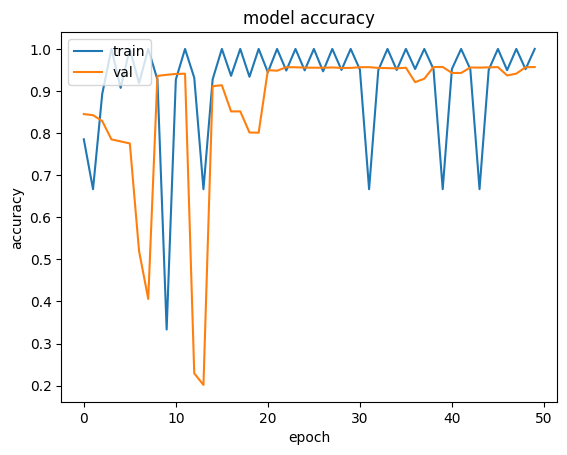

In [15]:
plt.plot(history.history["binary_accuracy"])
plt.plot(history.history["val_binary_accuracy"])
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "val"], loc="upper left")
plt.show()

In [16]:
def save_model(model_id: str, model: Model, params: dict):
    model_path = f"./models/{model_id}.keras"
    model.save(model_path)
    params["history"] = history.history
    with open(f"./models/{model_id}.json", "w") as f:
        json.dump(params, f, indent=4)
    
    return model_path

In [17]:
model_path = save_model(model_id, model, params)

In [18]:
from tensorflow.keras import models

def inference(model_path, images_path):
    custom_objects = {
        'FeatureExtractionLayer': FeatureExtractionLayer,
        'hard_tanh': hard_tanh
    }
    model = models.load_model(model_path, custom_objects=custom_objects)

    image_paths = [os.path.join(images_path, fname) for fname in os.listdir(images_path)][:5]
    dummy_labels = [0] * len(image_paths)
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, dummy_labels))

    dataset = dataset.map(
        lambda path, label: tf.py_function(
            preprocess, [path, label], [tf.float64, tf.float64, tf.int32]
        )
    )

    dataset = dataset.map(set_shapes)
    dataset = dataset.map(lambda frt, fpt, label: {'rich_texture': frt, 'poor_texture': fpt})
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    predictions = model.predict(dataset, batch_size=batch_size)

    return predictions

In [19]:
preds = inference(model_path, "./data/AI recognition dataset/fakeV2/fake-v2")

/home/llbs/www/cin/deep-learning/ai-generation-detection/.venv/lib/python3.12/site-packages/keras/src/layers/layer.py:396: UserWarning: `build()` was called on layer 'feature_extraction_layer_rich_texture', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/home/llbs/www/cin/deep-learning/ai-generation-detection/.venv/lib/python3.12/site-packages/keras/src/layers/layer.py:396: UserWarning: `build()` was called on layer 'feature_extraction_layer_poor_texture', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


In [20]:
preds

array([[0.991],
       [1.   ],
       [0.998],
       [0.998],
       [0.873]], dtype=float16)

In [21]:
preds_real = inference(model_path, "./data/AI recognition dataset/real")
preds_real

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


array([[4.314e-03],
       [6.905e-04],
       [9.697e-01],
       [6.610e-02],
       [2.711e-02]], dtype=float16)